# Evoked Excitatory Postsynaptic Currents (EPSCs)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Synaptic_currents" folder

In [2]:
data_folder = "data/7-Synaptic_currents"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/7-Synaptic_currents


['data/7-Synaptic_currents/2025_06_13_0008.abf',
 'data/7-Synaptic_currents/2025_06_13_0020.abf',
 'data/7-Synaptic_currents/2025_06_13_0021.abf',
 'data/7-Synaptic_currents/2025_06_13_0022_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0019.abf',
 'data/7-Synaptic_currents/2025_06_13_0018.abf',
 'data/7-Synaptic_currents/2025_06_13_0023_100hz.abf',
 'data/7-Synaptic_currents/2025_06_13_0016.abf',
 'data/7-Synaptic_currents/2025_06_13_0017.abf',
 'data/7-Synaptic_currents/2025_06_13_0015.abf',
 'data/7-Synaptic_currents/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [3]:
data_file = 'data/7-Synaptic_currents/2025_06_13_0022_100hz.abf'

Now we can load the file and plot the raw data:

In [6]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

Trace('2025_06_13_0022_100hz.abf')
Number of sweeps: 10
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


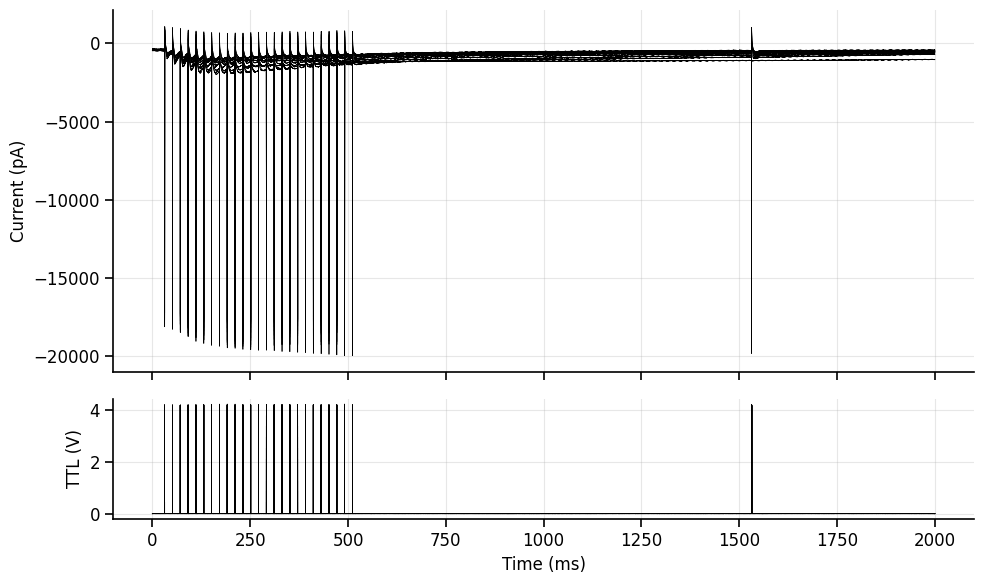

In [8]:
time_units = 'ms'
traces.plot(plot_ttl=True, plot_voltage=False, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [9]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [-382.0007 -465.5518 -461.7188 ... -413.9038 -381.2805 -365.4724]
Baseline voltages: [-1392.6268 -1392.8051 -1392.7294 ... -1392.5438 -1392.6049 -1392.5255]


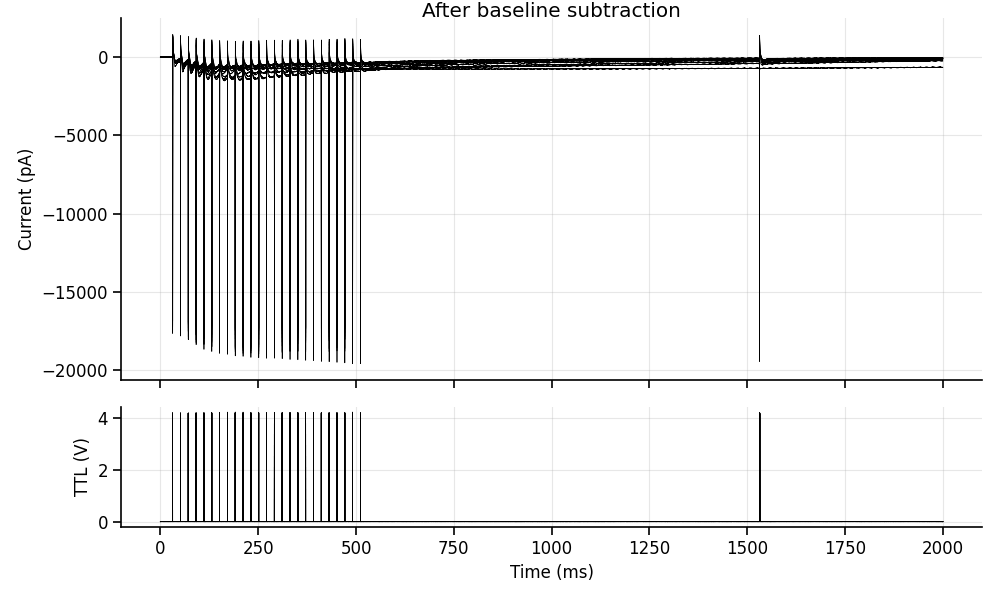

In [10]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 10, 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'all')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1, ax2 = traces.plot(plot_voltage=False, plot_ttl=True, time_units='ms', sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [11]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

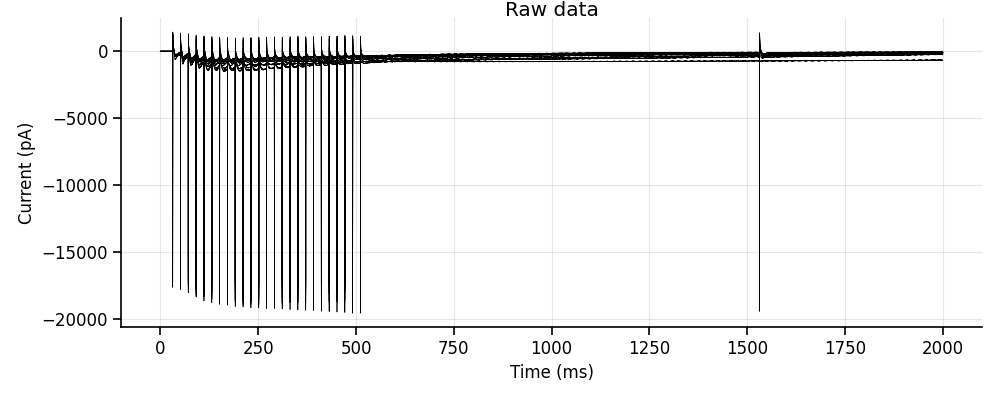

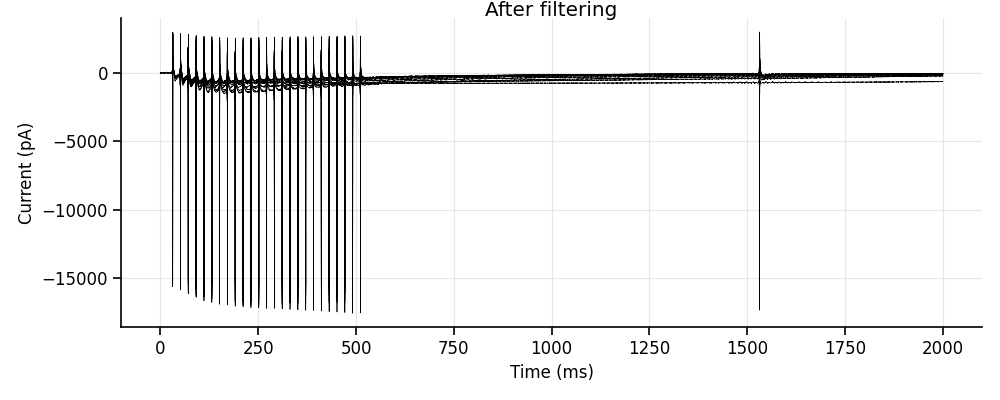

In [12]:
if apply_filtering:
    filtered_traces = traces
    # # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    # filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    %matplotlib widget
    # %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [13]:
if apply_filtering:
    traces=filtered_traces

## 3. Measure cumulative EPSCs/IPSCs amplitudes

In [14]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=-5000, 
                                    polarity='negative', 
                                    time_units=time_units, 
                                    channel='current', sweep=0)
# traces.get_ttl_events(threshold=0.5, edge='rising', time_units='ms')
print(f"Stim times: {stim_times} ms")

Stim times: [  31.4   51.4   71.4 ...  491.4  511.4 1531.4] ms


Choose a window size around each stim

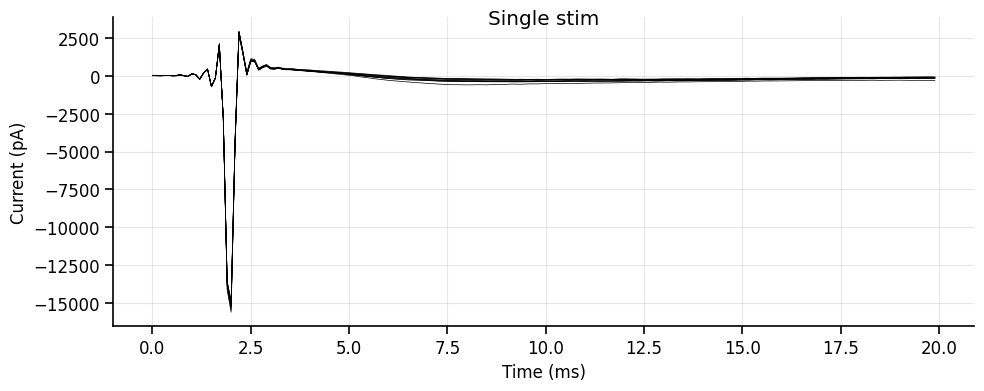

In [27]:
window_size = 20 #ms

stim_time = stim_times[0]
trace_crop = traces.crop(timepoint=stim_time-2, window=window_size, time_units=time_units)
ax = trace_crop.plot(plot_voltage=False, plot_ttl=False, time_units=time_units, sweep='all')
# ax.set_ylim(axis_y_range)
# ax.set_xlim(axis_x_range)
ax.set_title('Single stim',y=0.95)
plt.show()  

Measure cumulative currents

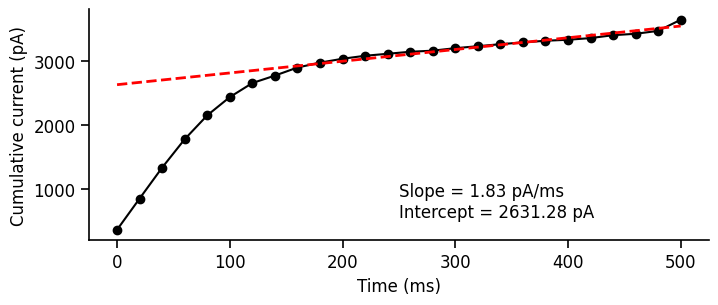

In [65]:
abs_currents = []
for i, stim_time in enumerate(stim_times):
    trace_crop = traces.crop(timepoint=stim_time-2, window=window_size, time_units=time_units)
    baseline_all_sweeps = trace_crop.current_data[:,0]
    current_all_sweeps, _ = trace_crop.get_measurements(start_time=3, end_time=15, measurement_type='min', time_units='ms')
    current_all_sweeps = current_all_sweeps - baseline_all_sweeps
    abs_current = np.abs(np.mean(current_all_sweeps))
    abs_currents.append(abs_current)   

cumulative_current = np.cumsum(abs_currents)
delta_t = round(stim_times[1] - stim_times[0])

%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
x = np.arange(0, delta_t*len(abs_currents), delta_t)
ax.plot(x, cumulative_current, '-o', color='k')
ax.set_ylabel('Cumulative current (pA)')
ax.set_xlabel(f"Time ({time_units})")

# Fit a line to the points
fit_start_point = 7
from scipy.stats import linregress
x_fit = x[fit_start_point:]
current_fit = cumulative_current[fit_start_point:]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, current_fit)
fit_line = slope * x + intercept
ax.plot(x, fit_line, linestyle='--', color='r', label='Fit', linewidth=2)
ylims = ax.get_ylim()
slope_unit = f"pA/{time_units}"
ax.annotate(f"Slope = {slope:.2f} {slope_unit} \nIntercept = {intercept:.2f} pA", xy=(0.5, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

# print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")


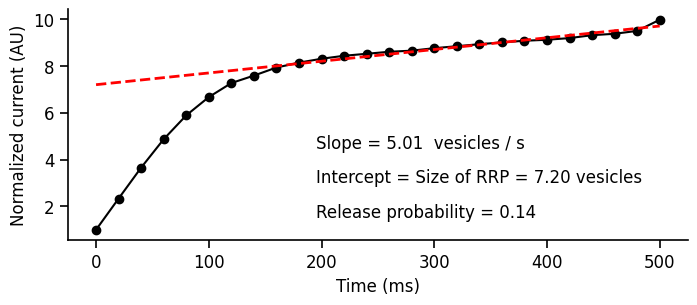

In [94]:
cumulative_current_norm = cumulative_current / cumulative_current[0]
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(x, cumulative_current_norm, '-o', color='k')
ax.set_ylabel('Normalized current (AU)')
ax.set_xlabel(f"Time ({time_units})")

# Fit a line to the points
fit_start_point = 7
from scipy.stats import linregress
x_fit = x[fit_start_point:]
current_fit = cumulative_current_norm[fit_start_point:]
slope, intercept, r_value, p_value, std_err = linregress(x_fit, current_fit)
fit_line = slope * x + intercept
ax.plot(x, fit_line, linestyle='--', color='r', label='Fit', linewidth=2)
ylims = ax.get_ylim()
ax.annotate(f"Slope = {1000*slope:.2f}  vesicles / s", xy=(0.4, 0.4), xycoords='axes fraction', fontsize=12)
ax.annotate(f"Intercept = Size of RRP = {intercept:.2f} vesicles", xy=(0.4, 0.25), xycoords='axes fraction', fontsize=12)
release_probability = cumulative_current_norm[0] / intercept
ax.annotate(f"Release probability = {release_probability:.2f}", xy=(0.4, 0.1), xycoords='axes fraction', fontsize=12)
plt.show()

# print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")
